In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os, sys

current_path = '/content/drive/My Drive/Colab Notebooks/300/'

os.chdir(current_path)

Mounted at /content/drive


### **Requirements**

In [ ]:
# !pip install statsmodels==0.12.2

# import statsmodels
# statsmodels.__version__

### load file list

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

interval = '30m'
date_path = './candlestick_concated/%s/2021-04-27/' % interval
file_list = os.listdir(date_path)

print((file_list))

['2021-04-27 BTCUSDT.xlsx', '2021-04-27 ETHUSDT.xlsx', '2021-04-27 BCHUSDT.xlsx', '2021-04-27 XRPUSDT.xlsx', '2021-04-27 EOSUSDT.xlsx', '2021-04-27 LTCUSDT.xlsx', '2021-04-27 ETCUSDT.xlsx', '2021-04-27 LINKUSDT.xlsx', '2021-04-27 XLMUSDT.xlsx', '2021-04-27 ADAUSDT.xlsx', '2021-04-27 XMRUSDT.xlsx', '2021-04-27 SXPUSDT.xlsx', '2021-04-27 KAVAUSDT.xlsx', '2021-04-27 BANDUSDT.xlsx', '2021-04-27 DASHUSDT.xlsx', '2021-04-27 ZECUSDT.xlsx', '2021-04-27 XTZUSDT.xlsx', '2021-04-27 BNBUSDT.xlsx', '2021-04-27 ATOMUSDT.xlsx', '2021-04-27 ONTUSDT.xlsx', '2021-04-27 IOTAUSDT.xlsx', '2021-04-27 BATUSDT.xlsx', '2021-04-27 NEOUSDT.xlsx', '2021-04-27 QTUMUSDT.xlsx', '2021-04-27 WAVESUSDT.xlsx', '2021-04-27 MKRUSDT.xlsx', '2021-04-27 SNXUSDT.xlsx', '2021-04-27 DOTUSDT.xlsx', '2021-04-27 THETAUSDT.xlsx', '2021-04-27 ALGOUSDT.xlsx', '2021-04-27 KNCUSDT.xlsx', '2021-04-27 ZRXUSDT.xlsx', '2021-04-27 COMPUSDT.xlsx', '2021-04-27 OMGUSDT.xlsx']


### custom model

In [ ]:
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
# os.environ["CUDA_VISIBLE_DEVICES"]="0"

# %tensorflow_version 1.x

import keras
import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.misc 
from math import sqrt 
import itertools
from IPython.display import display

%matplotlib inline

# from keras.utils import plot_model
import keras.backend as K
from keras.models import Model, Sequential
import keras.layers as layers
from keras.optimizers import Adam, SGD
from keras.regularizers import l1, l2

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import precision_score, recall_score, precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix


gdrive_path = current_path

num_classes = 2

def FER_Model(input_shape):
    # first input model
    visible = layers.Input(shape=input_shape, name='input')
    
    net = layers.Conv2D(32, kernel_size=3, padding='same', kernel_initializer='he_normal')(visible)
    # net = layers.Conv2D(256, kernel_size=3, padding='same', kernel_initializer='he_normal')(visible)
    # net = layers.BatchNormalization()(net)
    net = layers.LeakyReLU()(net)

    net = layers.Conv2D(64, kernel_size=3, padding='same', kernel_initializer='he_normal')(net)
    # net = layers.Conv2D(128, kernel_size=3, padding='same', kernel_initializer='he_normal')(net)
    # net = layers.BatchNormalization()(net)
    # net = layers.Activation('relu')(net)
    net = layers.LeakyReLU()(net)
    # net = layers.MaxPool2D(pool_size=2)(net)
    # net = layers.AveragePooling2D(padding='same')(net)

    shortcut_1 = net

    # net = layers.Conv2D(64, kernel_size=3, padding='same', kernel_initializer='he_normal')(net)
    net = layers.Conv2D(128, kernel_size=3, padding='same', kernel_initializer='he_normal')(net)
    net = layers.LeakyReLU()(net)

    net = layers.Conv2D(256, kernel_size=3, padding='same', kernel_initializer='he_normal')(net)
    # net = layers.BatchNormalization()(net)
    # net = layers.Activation('relu')(net)
    net = layers.LeakyReLU()(net)
    # net = layers.MaxPool2D(pool_size=2)(net)

    shortcut_2 = net

#     net = layers.Conv2D(256, kernel_size=3, padding='same')(net)
#     # net = layers.Activation('relu')(net)
#     net = layers.LeakyReLU()(net)
#     net = layers.MaxPool2D(pool_size=2)(net)

#     shortcut_3 = net

#     net = layers.Conv2D(128, kernel_size=1, padding='same')(net)
#     # net = layers.Activation('relu')(net)
#     net = layers.LeakyReLU()(net)
#     net = layers.MaxPool2D(pool_size=2)(net)

    net = layers.Flatten()(net)
    net = layers.Dense(128)(net)
    net = layers.LeakyReLU()(net)

    net = layers.Dense(64)(net)
    net = layers.LeakyReLU()(net)

    net = layers.Dense(num_classes, activation='softmax')(net)

    # create model 
    model = Model(inputs=visible, outputs=net)
    # summary layers
    # print(model.summary())
    
    return model

### all in one loop

In [ ]:

from funcs_indicator import *
import matplotlib.pyplot as plt

# import mpl_finance as mf


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


start_stamp = 0
# start_stamp = datetime.timestamp(pd.to_datetime('2021-02-12'))
print("start_stamp :", start_stamp)
# break

np.random.shuffle(file_list)
candis = file_list

long_index = 0
leverage = 5
prev_x = None
total_x = None


#           load saved npy & trained model        #
load_npy = False
load_model = False


seed = 1
random_state = 201
np.random.seed(seed)

fee = 0.0006
lvrg = 5

for i in range(len(candis)):

  keys = [candis[i]]

  #     we already predict eth      #
  # if 'eth'.upper() in candis[i]:
  #   continue

  # if 'comp'.upper() not in candis[i]:
  #   continue

  for key in keys:  
    
    ohlcv = pd.read_excel(date_path + key, index_col=0)
    print('len(ohlcv) :', len(ohlcv))

        
    #       long      #
    pr = (ohlcv['close'].pct_change() - fee) * lvrg + 1    

    #       long liqudation     #
    lq = (ohlcv['low'] / ohlcv['close'].shift(1) - fee - 1) * lvrg + 1

    #       short       # <-- 이거를 단순히 minus 를 붙여도 되는걸까
    s_pr = (-ohlcv['close'].pct_change() - fee) * lvrg + 1

    #       short liqudation     #
    # s_lq = (ohlcv['high'] / ohlcv['close'].shift(1) - fee) * lvrg + 1
    

    #       fill na with 1.0      #
    pr = np.where(np.isnan(pr), 1, pr)
    s_pr = np.where(np.isnan(s_pr), 1, pr)
    lq = np.where(np.isnan(lq), 1, lq)


    #       set lq      #
    pr = np.where((pr != 1) & (lq <= 0), 0, pr)

    # print("len(pr[pr < 0]) :", len(pr[pr < 0]))
    # break

    org_wr = len(pr[pr > 1]) / len(pr[pr != 1])

    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.plot(np.cumprod(pr))
    plt.title("%s\norg_wr : %.3f\n acc_pr : %.3f" % (key, org_wr, np.cumprod(pr)[-1]))


    #                    strat                   #

    # strat_pr = np.where((ohlcv['close'].shift(1) < ohlcv['close'].shift(2)) & 
    #                     (ohlcv['close'].shift(2) < ohlcv['close'].shift(3)), pr, 1)


    # strat_pr = np.where((ohlcv['close'].shift(1) < ohlcv['close'].shift(2)) & 
    #                     (ohlcv['close'].shift(2) > ohlcv['close'].shift(3)) & 
    #                     (ohlcv['close'].shift(3) > ohlcv['close'].shift(4)) & 
    #                     (ohlcv['close'].shift(4) < ohlcv['close'].shift(5)), pr, 1)


    strat_pr = np.where((ohlcv['close'].shift(1) < ohlcv['close'].shift(2)) & 
                        (ohlcv['close'].shift(2) > ohlcv['close'].shift(3)) & 
                        (ohlcv['close'].shift(3) > ohlcv['close'].shift(4)) & 
                        (ohlcv['close'].shift(4) < ohlcv['close'].shift(5)) & 
                        (ohlcv['close'].shift(5) < ohlcv['close'].shift(6)), pr, 1)
    
    # strat_pr = np.where((ohlcv['high'].shift(2) > ohlcv['high'].shift(3))& 
    #                     (ohlcv['close'].shift(1) > ohlcv['close'].shift(2)), pr, 1)


    wr = len(strat_pr[strat_pr > 1]) / len(strat_pr[strat_pr != 1])

    plt.subplot(122)
    plt.plot(np.cumprod(strat_pr))
    plt.title("%s\norg_wr : %.3f\n wr : %.5f\nacc_pr : %.3f" % (key, org_wr, wr, np.cumprod(strat_pr)[-1]))


    # #                  sl cut                #
    # sl_line = ohlcv['low'].rolling(250).min().shift(1)
    # # sl_line = ohlcv['low'].shift(1)

    # strat_pr_sl = np.where((strat_pr != 1) & (sl_line > ohlcv['low']), 
    #                      1 + lvrg * (sl_line / ohlcv['close'].shift(1) - 1 - fee), strat_pr)


    # wr_sl = len(strat_pr_sl[strat_pr_sl > 1]) / len(strat_pr_sl[strat_pr_sl != 1])
    # # wl_pr_ratio = np.mean(strat_pr[strat_pr > 1]) / np.mean(strat_pr[strat_pr < 1])
    # # wl_pr_ratio = np.cumprod(strat_pr[strat_pr > 1])[-1] / np.cumprod(strat_pr[strat_pr < 1])[-1]

    # plt.subplot(122)
    # plt.plot(np.cumprod(strat_pr_sl))
    # plt.title("%s\norg_pr : %.3f\n wr : %.5f\nacc_pr : %.3f" % (key, org_wr, wr_sl, np.cumprod(strat_pr_sl)[-1]))


    plt.show()
    # break

    # period = 45
    period = 5
    symbol_name = key.split(' ')[1].split('.')[0]      

    x_save_path = current_path + 'npy/' + '%s_cnn_updown_x_train_rascend_ohlcv_lq_%s_tssplit.npy' % (period, symbol_name)
    pr_save_path = current_path + 'npy/' + '%s_cnn_updown_pr_train_rascend_ohlcv_lq_%s_tssplit.npy' % (period, symbol_name)



    if not load_npy:

      from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
      from sklearn.model_selection import train_test_split
      from datetime import datetime

      from funcs_indicator import *

      def min_max_scale(npy_x):

        return (npy_x - np.min(npy_x)) / (np.max(npy_x) - np.min(npy_x))


      #       set data features : ohlc, v, ep
      time_index = ohlcv.index[np.sum(np.isnan(pr)):]

      sliced_ohlcv = ohlcv[np.sum(np.isnan(pr)):]

      #       scale with price    #
      ohlc = ohlcv.iloc[np.sum(np.isnan(pr)):, :4]      

      ha_ohlc = heikinashi(sliced_ohlcv).iloc[:, :4]
      sar = lucid_sar(sliced_ohlcv)
      ema1, ema2, ema3 = ema_ribbon(sliced_ohlcv)
      senkou1, senkou2 = ichimoku(sliced_ohlcv)

      #     min max scale   #
      vol = ohlcv.iloc[np.sum(np.isnan(pr)):, [4]]
      # vol = sliced_ohlcv.iloc[np.sum(np.isnan(pr)):, [4]]

      pr_list = pr[np.sum(np.isnan(pr)):]
      print("len(ohlc) :", len(ohlc))
      print("len(pr_list) :", len(pr_list))

      # break


      #       set params    #
      # period = 45
      key_i = i

      plotting = True

      data_x, data_pr, data_updown = [], [], []
      data_index = []

      for i in range(period, len(ohlc)):

        #   pr_list != 1 인 데이터만 사용한다
        # if 1:
        if pr_list[i] != 1:

          min_max = MinMaxScaler()
          
          #   prediction 을 제외한 이전 데이터를 사용해야한다
          temp_ohlc = ohlc.iloc[i - period : i].values
          # temp_long_ep = long_ep[i - period : i]          
          temp_ha_ohlc = ha_ohlc.iloc[i - period : i].values
          temp_sar = sar.iloc[i - period : i].values.reshape(-1, 1)
          temp_ema1 = ema1.iloc[i - period : i].values.reshape(-1, 1)
          temp_ema2 = ema2.iloc[i - period : i].values.reshape(-1, 1)
          temp_ema3 = ema3.iloc[i - period : i].values.reshape(-1, 1)
          temp_senkou1 = senkou1.iloc[i - period : i].values.reshape(-1, 1)
          temp_senkou2 = senkou2.iloc[i - period : i].values.reshape(-1, 1)      

          temp_close = min_max_scale(temp_ohlc[:, [3]])    

          price_data = np.hstack((temp_ohlc, temp_ha_ohlc, temp_sar, temp_ema1, temp_ema2, temp_ema3, temp_senkou1, temp_senkou2))

          if np.isnan(np.sum(price_data)):
            continue

          # print("price_data[:10] :", price_data[:10])
          # print("temp_ohlc.shape :", temp_ohlc.shape)
          # print("temp_long_ep.shape :", temp_long_ep.shape)
          # print("temp_ha_ohlc.shape :", temp_ha_ohlc.shape)
          # print("price_data.shape :", price_data.shape)

          if plotting:
            plt.plot(price_data)
            plt.show()

          ind_temp_ohlc = min_max_scale(temp_ohlc)
          temp_price_data = min_max_scale(price_data)
          # temp_price_data = (price_data - np.min(price_data)) / (np.max(price_data) - np.min(price_data))


          if plotting:

            plt.plot(ind_temp_ohlc)
            plt.show()
            plt.plot(temp_price_data)
            plt.show()

            plotting = False
          # break

          #   vol -> min_max
          temp_vol = min_max.fit_transform(vol.iloc[i - period : i].values.reshape(-1, 1))
          
          #                   feature selection                   #        
          temp_data = np.hstack((ind_temp_ohlc, temp_vol))

          # temp_data = trial_list[trial_number]
          # temp_data = np.hstack((temp_ohlc[:, [3]], temp_ohlc[:, [1]], temp_bbw))
          # temp_data = temp_ohlc[:, [3]]
          # temp_data = ind_temp_ohlc[:, [3]]
          # temp_data = temp_close

          if np.isnan(np.sum(temp_data)):
            continue

          data_x.append(temp_data)
          data_pr.append(pr_list[i])
          data_index.append(time_index[i])
          data_updown.append(ohlc['close'].iloc[i] / ohlc['open'].iloc[i])


      print('np.array(data_x).shape :', np.array(data_x).shape)
      # print(data_x[0])


      #       Reshape data for image deep - learning     #
      _, row, col = np.array(data_x).shape

      input_x = np.array(data_x).reshape(-1, row, col, 1).astype(np.float32)
      # input_x = np.array(data_x).reshape(-1, row, col).astype(np.float32)

      #     1c to 3c    #
      input_x = input_x * np.ones(3, dtype=np.float32)[None, None, None, :]
      # input_x = np.array(resize_npy(input_x))


      input_pr = np.array(data_pr).reshape(-1, 1).astype(np.float32)
      input_ud = np.array(data_updown).reshape(-1, 1).astype(np.float32)
      input_index = np.array(data_index).reshape(-1, 1)
      print('input_x.shape :', input_x.shape)
      print('input_x.dtype :', input_x.dtype)
      print('input_pr.shape :', input_pr.shape)
      print('input_ud.shape :', input_ud.shape)
      print('input_index.shape :', input_index.shape)


      # x_train_, x_test, pr_train_, pr_test, ud_train_, ud_test = train_test_split(input_x, input_pr, input_ud, test_size=0.4, shuffle=False, random_state=random_state)
      # x_train, x_val, pr_train, pr_val, ud_train, ud_val = train_test_split(x_train_, pr_train_, ud_train_, test_size=0.25, shuffle=False, random_state=random_state)

      #     do stacking   #
      # if prev_x is None:
      prev_x = input_x
      prev_pr = input_pr
      prev_ud = input_ud
      prev_index = input_index

      total_x = input_x
      total_pr = input_pr
      total_ud = input_ud
      total_index = input_index

      # else:
      #   total_x = np.vstack((prev_x, input_x))
      #   total_pr = np.vstack((prev_pr, input_pr))
      #   total_ud = np.vstack((prev_ud, input_ud)) 
      #   total_index = np.vstack((prev_index, input_index)) 

      #   prev_x = total_x
      #   prev_pr = total_pr
      #   prev_ud = total_ud
      #   prev_index = total_index

      print('total_x.shape :', total_x.shape)
      print('total_pr.shape :', total_pr.shape)
      print('total_ud.shape :', total_ud.shape)
      print('prev_index.shape :', prev_index.shape)


      # _, row, col, _ = input_x.shape
      # _, row, col = input_x.shape

      #       split new test      #

      seed = 1
      random_state = 201
      np.random.seed(seed)
      from sklearn.model_selection import train_test_split


      #         get unique timestamp      #
      print(np.unique(total_index, return_counts=True))
      uniq_stamp = np.unique(total_index)

      #                 don't shuffle timeseries data                 #
      stamp_train_, stamp_test = train_test_split(uniq_stamp, test_size=0.2, shuffle=False, random_state=random_state)
      stamp_train, stamp_val = train_test_split(stamp_train_, test_size=0.25, shuffle=False, random_state=random_state)

      print("stamp_train.shape :", stamp_train.shape)
      print("stamp_val.shape :", stamp_val.shape)
      print("stamp_test.shape :", stamp_test.shape)
      # break


      #         split data by stamp     #
      x_train, x_val, x_test = [], [], []
      pr_train, pr_val, pr_test = [], [], []
      index_train, index_val, index_test = [], [], []


      from tqdm.notebook import tqdm

      np.random.shuffle(total_index)

      for i in tqdm(range(len(total_index))):

        if total_index[i] in stamp_train:
          x_train.append(total_x[i])
          pr_train.append(total_pr[i])
          index_train.append(total_index[i])

        elif total_index[i] in stamp_val:
          x_val.append(total_x[i])
          pr_val.append(total_pr[i])
          index_val.append(total_index[i])
        
        elif total_index[i] in stamp_test:
          x_test.append(total_x[i])
          pr_test.append(total_pr[i])
          index_test.append(total_index[i])


      x_train = np.array(x_train)
      x_val = np.array(x_val)
      x_test = np.array(x_test)

      pr_train = np.array(pr_train)
      pr_val = np.array(pr_val)
      pr_test = np.array(pr_test)

      index_train = np.array(index_train)
      index_val = np.array(index_val)
      index_test = np.array(index_test)
        
      print("x_train.shape :", x_train.shape) # x_train.shape : (3807, 90, 12, 3)
      print("x_val.shape :", x_val.shape) # x_train.shape : (3807, 90, 12, 3)
      print("x_test.shape :", x_test.shape) # x_train.shape : (3807, 90, 12, 3)


      np.save(x_save_path, x_train)
      np.save(x_save_path.replace('x_train', 'x_val'), x_val)
      np.save(x_save_path.replace('x_train', 'x_test'), x_test)
      # np.save(x_save_path.replace('x_train', 'new_input_x'), new_input_x)
      print('x series saved !')

      np.save(pr_save_path, pr_train)
      np.save(pr_save_path.replace('pr_train', 'pr_val'), pr_val)
      np.save(pr_save_path.replace('pr_train', 'pr_test'), pr_test)
      # np.save(pr_save_path.replace('pr_train', 'new_input_pr'), new_input_pr)
      print('pr series saved !')

    else:
      
      x_train = np.load(x_save_path)
      x_val = np.load(x_save_path.replace('x_train', 'x_val'))
      x_test = np.load(x_save_path.replace('x_train', 'x_test'))
      print('x series loaded !')


      pr_train = np.load(pr_save_path)
      pr_val = np.load(pr_save_path.replace('pr_train', 'pr_val'))
      pr_test = np.load(pr_save_path.replace('pr_train', 'pr_test'))
      print('y series loaded !')




    #       pr_thresh by percentage 0.285     #
    plt.plot(pr)
    plt.show()
    
    sorted_pr = sorted(pr, reverse=True)
    pct = 0.285
    len_pct = int(len(pr) * pct)
    pr_thresh = sorted_pr[len_pct]
    print("pr_thresh :", pr_thresh)

    from keras.utils import np_utils

    # from keras.preprocessing.image import ImageDataGenerator 
    from sklearn.utils import class_weight


    def class_ratio(in_list):

      return in_list / in_list[1]
      
    y_train = np.where(pr_train > pr_thresh, 1, 0)
    y_test = np.where(pr_test > pr_thresh, 1, 0)
    y_val = np.where(pr_val > pr_thresh, 1, 0)

    print('x_train.shape :', x_train.shape)
    print('x_test.shape :', x_test.shape)
    print('x_val.shape :', x_val.shape)
    print('y_train.shape :', y_train.shape)
    print('y_test.shape :', y_test.shape)
    print('y_val.shape :', y_val.shape)

    # try:
    print('np.unique(y_train, return_counts=True :', np.unique(y_train, return_counts=True), class_ratio(np.unique(y_train, return_counts=True)[1]))
    print('np.unique(y_val, return_counts=True :', np.unique(y_val, return_counts=True), class_ratio(np.unique(y_val, return_counts=True)[1]))
    print('np.unique(y_test, return_counts=True :', np.unique(y_test, return_counts=True), class_ratio(np.unique(y_test, return_counts=True)[1]))

    # except Exception as e:
      # print(e)

    label = y_train.reshape(-1, )
    class_weights = class_weight.compute_class_weight('balanced', 
                                                        classes=np.unique(label),
                                                        y=label)
    class_weights = dict(enumerate(class_weights))
    print('class_weights :', class_weights)

    # sample_weight = np.ones(shape=(len(y_train),))
    # sample_weight[(y_train == 1).reshape(-1,)] = 1.5
    # print('sample_weight[:20] :', sample_weight[:20])

    num_classes = 2

    print('np.isnan(np.sum(x_train)) :', np.isnan(np.sum(x_train)))
    print('np.isnan(np.sum(x_val)) :', np.isnan(np.sum(x_val)))
    print('np.isnan(np.sum(x_test)) :', np.isnan(np.sum(x_test)))

    print('np.isnan(np.sum(y_train)) :', np.isnan(np.sum(y_train)))
    print('np.isnan(np.sum(y_val)) :', np.isnan(np.sum(y_val)))
    print('np.isnan(np.sum(y_test)) :', np.isnan(np.sum(y_test)))

    y_train_ohe = np_utils.to_categorical(y_train, num_classes)
    y_val_ohe = np_utils.to_categorical(y_val, num_classes)
    y_test_ohe = np_utils.to_categorical(y_test, num_classes)
    print('y_train_ohe.shape :', y_train_ohe.shape)
    print('y_val_ohe.shape :', y_val_ohe.shape)
    print('y_test_ohe.shape :', y_test_ohe.shape)

    from keras.preprocessing.image import ImageDataGenerator 

    datagen = ImageDataGenerator( 
        # rotation_range = 45,
        # zoom_range = 0.5,
        # shear_range = 0.5,
        # horizontal_flip = True,
        # vertical_flip = True,
        # width_shift_range=0.5,
        # height_shift_range=0.5,
        # fill_mode = 'nearest'
        )

    valgen = ImageDataGenerator( 
        )

    datagen.fit(x_train)
    valgen.fit(x_val)


    batch_size = 512


    for x_batch, _ in datagen.flow(x_train, y_train_ohe, batch_size=9):

        plt.suptitle("train x_batch")

        for i in range(0, 9): 
            plt.subplot(330 + 1 + i) 
            # resized = cv2.resize(x_batch[i].reshape(row, col), (row * 2, col * 10))
            # cmapped = plt.cm.Set1(resized)
            # plt.imshow(cmapped)
            # plt.imshow(x_batch[i].reshape(row, col))
            plt.imshow(x_batch[i])
            plt.axis('off') 
        plt.show() 
        break

    for x_batch, _ in valgen.flow(x_val, y_val_ohe, batch_size=9):

        plt.suptitle("val x_batch")

        for i in range(0, 9): 
            plt.subplot(330 + 1 + i) 
            # resized = cv2.resize(x_batch[i].reshape(row, col), (row * 2, col * 10))
            # cmapped = plt.cm.Set1(resized)
            # plt.imshow(cmapped)
            # plt.imshow(x_batch[i].reshape(row, col))
            plt.imshow(x_batch[i])
            plt.axis('off') 
        plt.show() 
        break
        
    train_flow = datagen.flow(x_train, y_train_ohe, batch_size=batch_size) 
    val_flow = valgen.flow(x_val, y_val_ohe, batch_size=batch_size) 
    # break

    

    ckpt_path = current_path + 'ckpt/'
    board_path = current_path + 'graph/'

    # batch_size = 512

    K.clear_session()


    #       we can use trained without lqset    #
    model_name = 'classifier_%s_cnn_updown_rascend_285_%s_tvnon_shuffle.h5' % (period, symbol_name)

    if not load_model:

      from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

      model = FER_Model(input_shape=x_train.shape[1:])
      opt = Adam(lr=0.00001, decay=0.000005)
      # opt = Adam(lr=0.001, decay=0.0005)
      model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

      checkpoint = ModelCheckpoint(ckpt_path + model_name, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
      checkpoint2 = TensorBoard(log_dir=board_path,
                                histogram_freq=0,
                                write_graph=True,
                                write_images=True)
      checkpoint3 = EarlyStopping(monitor='val_loss', patience=250)
      callbacks_list = [checkpoint, checkpoint2, checkpoint3]
      # callbacks_list = [checkpoint, checkpoint2]

      # keras.callbacks.Callback 로 부터 log 를 받아와 history log 를 작성할 수 있다.

      # we iterate 200 times over the entire training set
      num_epochs = 1000
      history = model.fit_generator(train_flow, 
                          steps_per_epoch=len(x_train) / batch_size, 
                          epochs=num_epochs,  
                          verbose=2,  
                          callbacks=callbacks_list,
                          class_weight=class_weights,
                          validation_data=val_flow,  
                          validation_steps=len(x_val) / batch_size,
                          shuffle=False)
      
    
    ckpt_path = current_path + 'ckpt/'
    board_path = current_path + 'graph/'


    model = keras.models.load_model(ckpt_path + model_name)

    test_result = model.predict(x_test)
    # test_result = model.predict(test_set)

    print('test_result.shape :', test_result.shape)
    # print('pr_val.shape :', pr_val.shape)

    y_score = test_result[:, [1]]
    print('y_test[:5] :', y_test.reshape(-1,)[:5])
    # print('np.unique(y_test) :', np.unique(y_test, return_counts=True))
    print('y_score[:5] :', y_score[:5])
    # print('np.unique(y_score) :', np.unique(y_score, return_counts=True))

    print('y_test.shape :', y_test.shape)
    print('y_score.shape :', y_score.shape)

    print('len(y_test) :', len(y_test))

    #     precision recall curve   #
    precision, recall, threshold = precision_recall_curve(y_test, y_score)
    precision, recall = precision[:-1], recall[:-1]

    plt.plot(threshold, precision, label='precision')
    plt.plot(threshold, recall, label='recall')
    plt.legend()
    plt.title('precision recall')
    plt.show()
    # print(y_pred)


    # threshold = [0.65]
    # print('threshold :', threshold)
    # break

    acc_pr_bythr = []
    new_thresh = []

    for thresh in threshold:
      
      # if thresh < 0.5:
      #     continue

      y_pred = np.where(y_score[:, -1] > thresh, 1, 0)
      # print('y_pred.shape :', y_pred.shape)
      # print('y_pred :', y_pred)

      #     compare precision     #

      # print('precision :', precision_score(y_test, y_pred))
      # print('recall :', recall_score(y_test, y_pred))
      # print()

      # print('np.isnan(np.sum(x_test)) :', np.isnan(np.sum(x_test)))
      # print('np.isnan(np.sum(y_test)) :', np.isnan(np.sum(y_test)))

      # # plot_confusion_matrix(best_model, x_test, y_test, normalize=None)
      # # plt.show()  
      # print()

      #     check win-ratio improvement     #
      cmat = confusion_matrix(y_test, y_pred)
      # print(cmat)
      # print(np.sum(cmat, axis=1))

      test_size = len(y_test)
      test_pr_list = pr_test
      # print('origin ac_pr :', np.cumprod(test_pr_list)[-1])

      org_wr = np.sum(cmat, axis=1)[-1] / sum(np.sum(cmat, axis=1))
      ml_wr = cmat[1][1] / np.sum(cmat, axis=0)[-1]
      # print('win ratio improvement %.2f --> %.2f' % (org_wr, ml_wr))

      # print('pr_test.shape :', pr_test.shape)

      # print(y_pred)
      # print(test_pr_list)

      pred_pr_list = np.where(y_pred == 1, test_pr_list.reshape(-1, ), 1)

      # pred_pr_list = np.where(np.isnan(pred_pr_list), 1.0, pred_pr_list)
      # pred_pr_list = np.where(pred_pr_list == 0.0, 1.0, pred_pr_list)
      # print('pred_pr_list.shape :', pred_pr_list.shape)

      # if np.cumprod(test_pr_list)[-1] < np.cumprod(pred_pr_list)[-1]:
      #   print('accum_pr increased ! : %.3f --> %.3f' % (np.cumprod(test_pr_list)[-1], np.cumprod(pred_pr_list)[-1]))
      #   print('thresh :', thresh)
        
      # if len(threshold) == 1:
    #   plt.figure(figsize=(10, 5))
    #   plt.subplot(121)
    #   plt.plot(np.cumprod(test_pr_list))
    #   plt.title('%.3f' % (np.cumprod(test_pr_list)[-1]))
    # # plt.show()

    #   plt.subplot(122)
    #   plt.plot(np.cumprod(pred_pr_list))
    #   plt.title('%.3f' % (np.cumprod(pred_pr_list)[-1]))
    #   # plt.axvline(len(org_pr_test), linestyle='--', color='r')
    #   plt.show()


      acc_pr_bythr.append(np.cumprod(pred_pr_list)[-1])
      new_thresh.append(thresh)


    print('acc_pr_bythr :', acc_pr_bythr)

    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.plot(threshold, precision, label='precision')
    plt.plot(threshold, recall, label='recall')
    plt.legend()
    plt.title('precision recall')
    # plt.show()
    plt.subplot(122)
    plt.plot(new_thresh, acc_pr_bythr)
    plt.axhline(np.cumprod(test_pr_list)[-1], linestyle='--', color='r')
    plt.title(symbol_name)
    plt.show()
          



### save npy

In [ ]:
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
import pickle
from sklearn.model_selection import train_test_split
from datetime import datetime

from funcs_indicator import *

def min_max_scale(npy_x):

  return (npy_x - np.min(npy_x)) / (np.max(npy_x) - np.min(npy_x))


#       set data features : ohlc, v, ep
time_index = ohlcv.index[np.sum(np.isnan(pr)):]

sliced_ohlcv = ohlcv[np.sum(np.isnan(pr)):]

#       scale with price    #
ohlc = ohlcv.iloc[np.sum(np.isnan(pr)):, :4]      

ha_ohlc = heikinashi(sliced_ohlcv).iloc[:, :4]
sar = lucid_sar(sliced_ohlcv)
ema1, ema2, ema3 = ema_ribbon(sliced_ohlcv)
senkou1, senkou2 = ichimoku(sliced_ohlcv)

#     min max scale   #
vol = sliced_ohlcv.iloc[np.sum(np.isnan(pr)):, [4]]

pr_list = pr[np.sum(np.isnan(pr)):]
print("len(ohlc) :", len(ohlc))
print("len(pr) :", len(pr))

# break


#       set params    #
period = 45
key_i = i

plotting = True

data_x, data_pr, data_updown = [], [], []
data_index = []

for i in range(period, len(ohlc)):

  #   pr_list != 1 인 데이터만 사용한다
  # if 1:
  if pr_list[i] != 1:

    min_max = MinMaxScaler()
    
    #   prediction 을 제외한 이전 데이터를 사용해야한다
    temp_ohlc = ohlc.iloc[i - period : i].values
    # temp_long_ep = long_ep[i - period : i]          
    temp_ha_ohlc = ha_ohlc.iloc[i - period : i].values
    temp_sar = sar.iloc[i - period : i].values.reshape(-1, 1)
    temp_ema1 = ema1.iloc[i - period : i].values.reshape(-1, 1)
    temp_ema2 = ema2.iloc[i - period : i].values.reshape(-1, 1)
    temp_ema3 = ema3.iloc[i - period : i].values.reshape(-1, 1)
    temp_senkou1 = senkou1.iloc[i - period : i].values.reshape(-1, 1)
    temp_senkou2 = senkou2.iloc[i - period : i].values.reshape(-1, 1)      

    temp_close = min_max_scale(temp_ohlc[:, [3]])    

    price_data = np.hstack((temp_ohlc, temp_ha_ohlc, temp_sar, temp_ema1, temp_ema2, temp_ema3, temp_senkou1, temp_senkou2))

    if np.isnan(np.sum(price_data)):
      continue

    # print("price_data[:10] :", price_data[:10])
    # print("temp_ohlc.shape :", temp_ohlc.shape)
    # print("temp_long_ep.shape :", temp_long_ep.shape)
    # print("temp_ha_ohlc.shape :", temp_ha_ohlc.shape)
    # print("price_data.shape :", price_data.shape)

    if plotting:
      plt.plot(price_data)
      plt.show()

    ind_temp_ohlc = min_max_scale(temp_ohlc)
    temp_price_data = min_max_scale(price_data)
    # temp_price_data = (price_data - np.min(price_data)) / (np.max(price_data) - np.min(price_data))


    if plotting:

      plt.plot(ind_temp_ohlc)
      plt.show()
      plt.plot(temp_price_data)
      plt.show()

      plotting = False
    # break

    #   vol -> min_max
    temp_vol = min_max.fit_transform(vol.iloc[i - period : i].values.reshape(-1, 1))
    
    #                   feature selection                   #        
    temp_data = np.hstack((ind_temp_ohlc, temp_vol))

    # temp_data = trial_list[trial_number]
    # temp_data = np.hstack((temp_ohlc[:, [3]], temp_ohlc[:, [1]], temp_bbw))
    # temp_data = temp_ohlc[:, [3]]
    # temp_data = ind_temp_ohlc[:, [3]]
    # temp_data = temp_close

    if np.isnan(np.sum(temp_data)):
      continue

    data_x.append(temp_data)
    data_pr.append(pr_list[i])
    data_index.append(time_index[i])
    data_updown.append(ohlc['close'].iloc[i] / ohlc['open'].iloc[i])


print('np.array(data_x).shape :', np.array(data_x).shape)
# print(data_x[0])


#       Reshape data for image deep - learning     #
_, row, col = np.array(data_x).shape

input_x = np.array(data_x).reshape(-1, row, col, 1).astype(np.float32)
# input_x = np.array(data_x).reshape(-1, row, col).astype(np.float32)

#     1c to 3c    #
input_x = input_x * np.ones(3, dtype=np.float32)[None, None, None, :]
# input_x = np.array(resize_npy(input_x))


input_pr = np.array(data_pr).reshape(-1, 1).astype(np.float32)
input_ud = np.array(data_updown).reshape(-1, 1).astype(np.float32)
input_index = np.array(data_index).reshape(-1, 1)
print('input_x.shape :', input_x.shape)
print('input_x.dtype :', input_x.dtype)
print('input_pr.shape :', input_pr.shape)
print('input_ud.shape :', input_ud.shape)
print('input_index.shape :', input_index.shape)


# x_train_, x_test, pr_train_, pr_test, ud_train_, ud_test = train_test_split(input_x, input_pr, input_ud, test_size=0.4, shuffle=False, random_state=random_state)
# x_train, x_val, pr_train, pr_val, ud_train, ud_val = train_test_split(x_train_, pr_train_, ud_train_, test_size=0.25, shuffle=False, random_state=random_state)

#     do stacking   #
# if prev_x is None:
prev_x = input_x
prev_pr = input_pr
prev_ud = input_ud
prev_index = input_index

total_x = input_x
total_pr = input_pr
total_ud = input_ud
total_index = input_index

# else:
#   total_x = np.vstack((prev_x, input_x))
#   total_pr = np.vstack((prev_pr, input_pr))
#   total_ud = np.vstack((prev_ud, input_ud)) 
#   total_index = np.vstack((prev_index, input_index)) 

#   prev_x = total_x
#   prev_pr = total_pr
#   prev_ud = total_ud
#   prev_index = total_index

print('total_x.shape :', total_x.shape)
print('total_pr.shape :', total_pr.shape)
print('total_ud.shape :', total_ud.shape)
print('prev_index.shape :', prev_index.shape)


# _, row, col, _ = input_x.shape
# _, row, col = input_x.shape

#       split new test      #

seed = 1
random_state = 201
np.random.seed(seed)
from sklearn.model_selection import train_test_split


#         get unique timestamp      #
print(np.unique(total_index, return_counts=True))
uniq_stamp = np.unique(total_index)

#                 don't shuffle timeseries data                 #
stamp_train_, stamp_test = train_test_split(uniq_stamp, test_size=0.2, shuffle=False, random_state=random_state)
stamp_train, stamp_val = train_test_split(stamp_train_, test_size=0.25, shuffle=False, random_state=random_state)

print("stamp_train.shape :", stamp_train.shape)
print("stamp_val.shape :", stamp_val.shape)
print("stamp_test.shape :", stamp_test.shape)
# break


#         split data by stamp     #
x_train, x_val, x_test = [], [], []
pr_train, pr_val, pr_test = [], [], []
index_train, index_val, index_test = [], [], []


from tqdm.notebook import tqdm

np.random.shuffle(total_index)

for i in tqdm(range(len(total_index))):

  if total_index[i] in stamp_train:
    x_train.append(total_x[i])
    pr_train.append(total_pr[i])
    index_train.append(total_index[i])

  elif total_index[i] in stamp_val:
    x_val.append(total_x[i])
    pr_val.append(total_pr[i])
    index_val.append(total_index[i])
  
  elif total_index[i] in stamp_test:
    x_test.append(total_x[i])
    pr_test.append(total_pr[i])
    index_test.append(total_index[i])


x_train = np.array(x_train)
x_val = np.array(x_val)
x_test = np.array(x_test)

pr_train = np.array(pr_train)
pr_val = np.array(pr_val)
pr_test = np.array(pr_test)

index_train = np.array(index_train)
index_val = np.array(index_val)
index_test = np.array(index_test)
  
print("x_train.shape :", x_train.shape) # x_train.shape : (3807, 90, 12, 3)
print("x_val.shape :", x_val.shape) # x_train.shape : (3807, 90, 12, 3)
print("x_test.shape :", x_test.shape) # x_train.shape : (3807, 90, 12, 3)

symbol_name = key.split(' ')[1].split('.')[0]

x_save_path = current_path + 'npy/' + '%s_cnn_updown_x_train_rascend_ohlcv_%s_tssplit.npy' % (period, symbol_name)
pr_save_path = current_path + 'npy/' + '%s_cnn_updown_pr_train_rascend_ohlcv_%s_tssplit.npy' % (period, symbol_name)

np.save(x_save_path, x_train)
np.save(x_save_path.replace('x_train', 'x_val'), x_val)
np.save(x_save_path.replace('x_train', 'x_test'), x_test)
# np.save(x_save_path.replace('x_train', 'new_input_x'), new_input_x)
print('x series saved !')

np.save(pr_save_path, pr_train)
np.save(pr_save_path.replace('pr_train', 'pr_val'), pr_val)
np.save(pr_save_path.replace('pr_train', 'pr_test'), pr_test)
# np.save(pr_save_path.replace('pr_train', 'new_input_pr'), new_input_pr)
print('pr series saved !')
      

In [ ]:
def resize_npy(x):

  temp_x = []

  for d_i, data in enumerate(x):
    # resized_data = cv2.resize(data, (row * 2, col * 2)) --> input image 홰손된다
    # resized_data = data.repeat(2, axis=0).repeat(2, axis=1)
    data = data.repeat(2, axis=0).repeat(2, axis=1)
    # resized_data = data.repeat(1, axis=0).repeat(1, axis=1)
    # cmapped = plt.cm.Set1(resized_data)[:, :, :3]  # Drop Alpha Channel
    
    if d_i == 0:
      plt.imshow(data)
      plt.show()
      # plt.imshow(resized_data)
      # plt.show()
    # print('resized_data.shape :', resized_data.shape)
    # break
    temp_x.append(data)

  return temp_x

### load npy

In [ ]:
from keras.utils import np_utils

# from keras.preprocessing.image import ImageDataGenerator 
from sklearn.utils import class_weight


symbol_name = "SXPUSDT"
period = 45

x_save_path = current_path + 'npy/' + '%s_cnn_updown_x_train_rascend_ohlcv_%s_tssplit.npy' % (period, symbol_name)
pr_save_path = current_path + 'npy/' + '%s_cnn_updown_pr_train_rascend_ohlcv_%s_tssplit.npy' % (period, symbol_name)


x_train = np.load(x_save_path)
x_val = np.load(x_save_path.replace('x_train', 'x_val'))
x_test = np.load(x_save_path.replace('x_train', 'x_test'))
print('x series loaded !')


pr_train = np.load(pr_save_path)
pr_val = np.load(pr_save_path.replace('pr_train', 'pr_val'))
pr_test = np.load(pr_save_path.replace('pr_train', 'pr_test'))
print('y series loaded !')

# total_x = np.vstack((x_train, x_val, x_test))
# total_pr = np.vstack((pr_train, pr_val, pr_test))

# print("total_x.shape :", total_x.shape)

x series loaded !
y series loaded !


### rapid pr selection

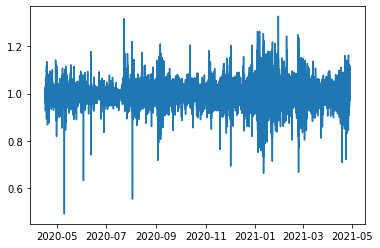

0.36131427304964536


In [ ]:
plt.plot(pr)
plt.show()

pr_thresh = 1.005
rapid_pct = len(pr[pr > pr_thresh]) / len(pr)

print(rapid_pct)

### class_weight & categorization

In [ ]:
from keras.utils import np_utils

# from keras.preprocessing.image import ImageDataGenerator 
from sklearn.utils import class_weight


def class_ratio(in_list):

  return in_list / in_list[1]
  
y_train = np.where(pr_train > pr_thresh, 1, 0)
y_test = np.where(pr_test > pr_thresh, 1, 0)
y_val = np.where(pr_val > pr_thresh, 1, 0)

print('x_train.shape :', x_train.shape)
print('x_test.shape :', x_test.shape)
print('x_val.shape :', x_val.shape)
print('y_train.shape :', y_train.shape)
print('y_test.shape :', y_test.shape)
print('y_val.shape :', y_val.shape)

# try:
print('np.unique(y_train, return_counts=True :', np.unique(y_train, return_counts=True), class_ratio(np.unique(y_train, return_counts=True)[1]))
print('np.unique(y_val, return_counts=True :', np.unique(y_val, return_counts=True), class_ratio(np.unique(y_val, return_counts=True)[1]))
print('np.unique(y_test, return_counts=True :', np.unique(y_test, return_counts=True), class_ratio(np.unique(y_test, return_counts=True)[1]))

# except Exception as e:
  # print(e)

label = y_train.reshape(-1, )
class_weights = class_weight.compute_class_weight('balanced', 
                                                    classes=np.unique(label),
                                                    y=label)
class_weights = dict(enumerate(class_weights))
print('class_weights :', class_weights)

# sample_weight = np.ones(shape=(len(y_train),))
# sample_weight[(y_train == 1).reshape(-1,)] = 1.5
# print('sample_weight[:20] :', sample_weight[:20])


print('np.isnan(np.sum(x_train)) :', np.isnan(np.sum(x_train)))
print('np.isnan(np.sum(x_val)) :', np.isnan(np.sum(x_val)))
print('np.isnan(np.sum(x_test)) :', np.isnan(np.sum(x_test)))

print('np.isnan(np.sum(y_train)) :', np.isnan(np.sum(y_train)))
print('np.isnan(np.sum(y_val)) :', np.isnan(np.sum(y_val)))
print('np.isnan(np.sum(y_test)) :', np.isnan(np.sum(y_test)))

y_train_ohe = np_utils.to_categorical(y_train, num_classes)
y_val_ohe = np_utils.to_categorical(y_val, num_classes)
y_test_ohe = np_utils.to_categorical(y_test, num_classes)
print('y_train_ohe.shape :', y_train_ohe.shape)
print('y_val_ohe.shape :', y_val_ohe.shape)
print('y_test_ohe.shape :', y_test_ohe.shape)

x_train.shape : (10755, 45, 5, 3)
x_test.shape : (3586, 45, 5, 3)
x_val.shape : (3585, 45, 5, 3)
y_train.shape : (10755, 1)
y_test.shape : (3586, 1)
y_val.shape : (3585, 1)
np.unique(y_train, return_counts=True : (array([0, 1]), array([6864, 3891])) [1.76407093 1.        ]
np.unique(y_val, return_counts=True : (array([0, 1]), array([2303, 1282])) [1.79641186 1.        ]
np.unique(y_test, return_counts=True : (array([0, 1]), array([2291, 1295])) [1.76911197 1.        ]
class_weights : {0: 0.7834353146853147, 1: 1.382035466461064}
np.isnan(np.sum(x_train)) : False
np.isnan(np.sum(x_val)) : False
np.isnan(np.sum(x_test)) : False
np.isnan(np.sum(y_train)) : False
np.isnan(np.sum(y_val)) : False
np.isnan(np.sum(y_test)) : False
y_train_ohe.shape : (10755, 2)
y_val_ohe.shape : (3585, 2)
y_test_ohe.shape : (3586, 2)


### augment

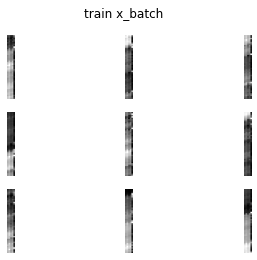

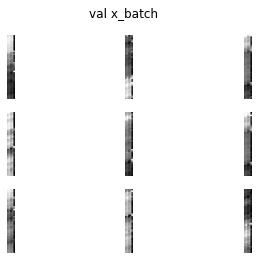

In [ ]:
from keras.preprocessing.image import ImageDataGenerator 

datagen = ImageDataGenerator( 
    # rotation_range = 45,
    # zoom_range = 0.5,
    # shear_range = 0.5,
    # horizontal_flip = True,
    # vertical_flip = True,
    # width_shift_range=0.5,
    # height_shift_range=0.5,
    # fill_mode = 'nearest'
    )

valgen = ImageDataGenerator( 
    )

datagen.fit(x_train)
valgen.fit(x_val)


batch_size = 512


for x_batch, _ in datagen.flow(x_train, y_train_ohe, batch_size=9):

    plt.suptitle("train x_batch")

    for i in range(0, 9): 
        plt.subplot(330 + 1 + i) 
        # resized = cv2.resize(x_batch[i].reshape(row, col), (row * 2, col * 10))
        # cmapped = plt.cm.Set1(resized)
        # plt.imshow(cmapped)
        # plt.imshow(x_batch[i].reshape(row, col))
        plt.imshow(x_batch[i])
        plt.axis('off') 
    plt.show() 
    break

for x_batch, _ in valgen.flow(x_val, y_val_ohe, batch_size=9):

    plt.suptitle("val x_batch")

    for i in range(0, 9): 
        plt.subplot(330 + 1 + i) 
        # resized = cv2.resize(x_batch[i].reshape(row, col), (row * 2, col * 10))
        # cmapped = plt.cm.Set1(resized)
        # plt.imshow(cmapped)
        # plt.imshow(x_batch[i].reshape(row, col))
        plt.imshow(x_batch[i])
        plt.axis('off') 
    plt.show() 
    break
    
train_flow = datagen.flow(x_train, y_train_ohe, batch_size=batch_size) 
val_flow = valgen.flow(x_val, y_val_ohe, batch_size=batch_size) 
# break

### train

In [ ]:

from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

ckpt_path = current_path + 'ckpt/'
board_path = current_path + 'graph/'

# batch_size = 512

model = FER_Model(input_shape=x_train.shape[1:])
opt = Adam(lr=0.00001, decay=0.000005)
# opt = Adam(lr=0.001, decay=0.0005)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

model_name = 'classifier_%s_cnn_updown_rascend_1005_%s_tvnon_shuffle.h5' % (period, symbol_name)



checkpoint = ModelCheckpoint(ckpt_path + model_name, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
checkpoint2 = TensorBoard(log_dir=board_path,
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
checkpoint3 = EarlyStopping(monitor='val_loss', patience=250)
callbacks_list = [checkpoint, checkpoint2, checkpoint3]
# callbacks_list = [checkpoint, checkpoint2]

# keras.callbacks.Callback 로 부터 log 를 받아와 history log 를 작성할 수 있다.

# we iterate 200 times over the entire training set
num_epochs = 1000
history = model.fit_generator(train_flow, 
                    steps_per_epoch=len(x_train) / batch_size, 
                    epochs=num_epochs,  
                    verbose=2,  
                    callbacks=callbacks_list,
                    class_weight=class_weights,
                    validation_data=val_flow,  
                    validation_steps=len(x_val) / batch_size,
                    shuffle=False)

### load model

In [ ]:
ckpt_path = current_path + 'ckpt/'
board_path = current_path + 'graph/'


model_name = 'classifier_%s_cnn_updown_rascend_101_%s_tvnon_shuffle.h5' % (period, symbol_name)


model = keras.models.load_model(ckpt_path + model_name)

### test

test_result.shape : (3586, 2)
y_test[:5] : [0 1 0 0 0]
y_score[:5] : [[0.04767541]
 [0.00195843]
 [0.1600004 ]
 [0.14308068]
 [0.00154134]]
y_test.shape : (3586, 1)
y_score.shape : (3586, 1)
len(y_test) : 3586


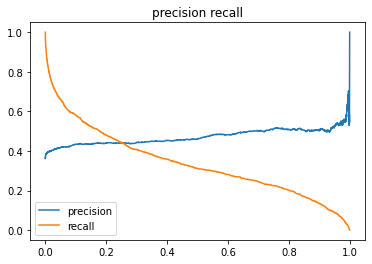

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in long_scalars


acc_pr_bythr : [5.2342257e-05, 5.224965e-05, 5.119804e-05, 4.92728e-05, 4.9822964e-05, 5.1722614e-05, 5.241118e-05, 5.2653213e-05, 5.4707263e-05, 5.469477e-05, 5.5414595e-05, 5.4917986e-05, 5.5296758e-05, 5.482614e-05, 5.5313794e-05, 5.619928e-05, 5.7341047e-05, 5.8005982e-05, 5.7726982e-05, 5.8714617e-05, 5.924952e-05, 5.9157777e-05, 6.0730683e-05, 6.09751e-05, 6.1022805e-05, 6.194849e-05, 6.286581e-05, 6.367981e-05, 6.4932676e-05, 6.5769455e-05, 6.7948844e-05, 6.841887e-05, 6.806048e-05, 6.849957e-05, 6.9895126e-05, 7.091783e-05, 7.1859926e-05, 7.350335e-05, 7.346305e-05, 7.395025e-05, 7.968566e-05, 7.8947196e-05, 7.8341516e-05, 7.918357e-05, 7.912106e-05, 8.1205275e-05, 8.341604e-05, 8.386569e-05, 8.3938816e-05, 8.564359e-05, 7.970025e-05, 8.0672995e-05, 8.083643e-05, 8.727269e-05, 8.9510206e-05, 8.959228e-05, 8.962243e-05, 8.8885776e-05, 9.023229e-05, 9.169206e-05, 9.0867565e-05, 9.033618e-05, 9.429348e-05, 9.3799725e-05, 9.566918e-05, 9.6586686e-05, 9.398621e-05, 9.4105475e-05, 9.

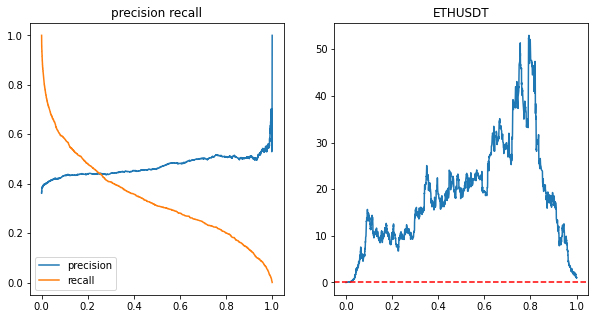

In [ ]:
test_result = model.predict(x_test)
# test_result = model.predict(test_set)

print('test_result.shape :', test_result.shape)
# print('pr_val.shape :', pr_val.shape)

y_score = test_result[:, [1]]
print('y_test[:5] :', y_test.reshape(-1,)[:5])
# print('np.unique(y_test) :', np.unique(y_test, return_counts=True))
print('y_score[:5] :', y_score[:5])
# print('np.unique(y_score) :', np.unique(y_score, return_counts=True))

print('y_test.shape :', y_test.shape)
print('y_score.shape :', y_score.shape)

print('len(y_test) :', len(y_test))

#     precision recall curve   #
precision, recall, threshold = precision_recall_curve(y_test, y_score)
precision, recall = precision[:-1], recall[:-1]

plt.plot(threshold, precision, label='precision')
plt.plot(threshold, recall, label='recall')
plt.legend()
plt.title('precision recall')
plt.show()
# print(y_pred)


# threshold = [0.65]
# print('threshold :', threshold)
# break

acc_pr_bythr = []
new_thresh = []

for thresh in threshold:
  
  # if thresh < 0.5:
  #     continue

  y_pred = np.where(y_score[:, -1] > thresh, 1, 0)
  # print('y_pred.shape :', y_pred.shape)
  # print('y_pred :', y_pred)

  #     compare precision     #

  # print('precision :', precision_score(y_test, y_pred))
  # print('recall :', recall_score(y_test, y_pred))
  # print()

  # print('np.isnan(np.sum(x_test)) :', np.isnan(np.sum(x_test)))
  # print('np.isnan(np.sum(y_test)) :', np.isnan(np.sum(y_test)))

  # # plot_confusion_matrix(best_model, x_test, y_test, normalize=None)
  # # plt.show()  
  # print()

  #     check win-ratio improvement     #
  cmat = confusion_matrix(y_test, y_pred)
  # print(cmat)
  # print(np.sum(cmat, axis=1))

  test_size = len(y_test)
  test_pr_list = pr_test
  # print('origin ac_pr :', np.cumprod(test_pr_list)[-1])

  org_wr = np.sum(cmat, axis=1)[-1] / sum(np.sum(cmat, axis=1))
  ml_wr = cmat[1][1] / np.sum(cmat, axis=0)[-1]
  # print('win ratio improvement %.2f --> %.2f' % (org_wr, ml_wr))

  # print('pr_test.shape :', pr_test.shape)

  # print(y_pred)
  # print(test_pr_list)

  pred_pr_list = np.where(y_pred == 1, test_pr_list.reshape(-1, ), 1.0)
  # pred_pr_list = np.where(np.isnan(pred_pr_list), 1.0, pred_pr_list)
  # pred_pr_list = np.where(pred_pr_list == 0.0, 1.0, pred_pr_list)
  # print('pred_pr_list.shape :', pred_pr_list.shape)

  # if np.cumprod(test_pr_list)[-1] < np.cumprod(pred_pr_list)[-1]:
  #   print('accum_pr increased ! : %.3f --> %.3f' % (np.cumprod(test_pr_list)[-1], np.cumprod(pred_pr_list)[-1]))
  #   print('thresh :', thresh)
    
  # if len(threshold) == 1:
#   plt.figure(figsize=(10, 5))
#   plt.subplot(121)
#   plt.plot(np.cumprod(test_pr_list))
#   plt.title('%.3f' % (np.cumprod(test_pr_list)[-1]))
# # plt.show()

#   plt.subplot(122)
#   plt.plot(np.cumprod(pred_pr_list))
#   plt.title('%.3f' % (np.cumprod(pred_pr_list)[-1]))
#   # plt.axvline(len(org_pr_test), linestyle='--', color='r')
#   plt.show()


  acc_pr_bythr.append(np.cumprod(pred_pr_list)[-1])
  new_thresh.append(thresh)


print('acc_pr_bythr :', acc_pr_bythr)

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(threshold, precision, label='precision')
plt.plot(threshold, recall, label='recall')
plt.legend()
plt.title('precision recall')
# plt.show()
plt.subplot(122)
plt.plot(new_thresh, acc_pr_bythr)
plt.axhline(np.cumprod(test_pr_list)[-1], linestyle='--', color='r')
plt.title(symbol_name)
plt.show()

In [ ]:
plt.subplot(122)
plt.plot(new_thresh, acc_pr_bythr)
plt.axhline(np.cumprod(test_pr_list)[-1], linestyle='--', color='r')
plt.axvline(new_thresh[np.argmax(acc_pr_bythr)], linestyle='--', color='r')
plt.title(symbol_name + '\n' + str(new_thresh[np.argmax(acc_pr_bythr)]))
plt.show()

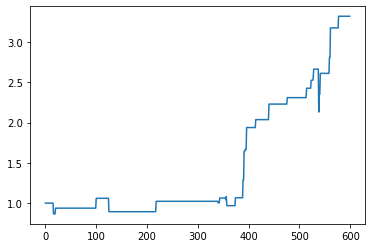

In [ ]:
thresh = 0.5866
y_pred = np.where(y_score[:600, -1] > thresh, 1, 0)
# print('y_pred.shape :', y_pred.shape)
# print('y_pred :', y_pred)

#     compare precision     #

# print('precision :', precision_score(y_test, y_pred))
# print('recall :', recall_score(y_test, y_pred))
# print()

# print('np.isnan(np.sum(x_test)) :', np.isnan(np.sum(x_test)))
# print('np.isnan(np.sum(y_test)) :', np.isnan(np.sum(y_test)))

# # plot_confusion_matrix(best_model, x_test, y_test, normalize=None)
# # plt.show()  
# print()

#     check win-ratio improvement     #
cmat = confusion_matrix(y_test[:len(y_pred)], y_pred)
# print(cmat)
# print(np.sum(cmat, axis=1))

test_size = len(y_test[:len(y_pred)])
test_pr_list = pr_test[:len(y_pred)]
# print('origin ac_pr :', np.cumprod(test_pr_list)[-1])

org_wr = np.sum(cmat, axis=1)[-1] / sum(np.sum(cmat, axis=1))
ml_wr = cmat[1][1] / np.sum(cmat, axis=0)[-1]
# print('win ratio improvement %.2f --> %.2f' % (org_wr, ml_wr))

# print('pr_test.shape :', pr_test.shape)

# print(y_pred)
# print(test_pr_list)
pred_pr_list = np.where(y_pred == 1, test_pr_list.reshape(-1, ), 1.0)
pred_pr_list = np.where(np.isnan(pred_pr_list), 1.0, pred_pr_list)
pred_pr_list = np.where(pred_pr_list == 0.0, 1.0, pred_pr_list)

plt.plot(np.cumprod(pred_pr_list))
plt.show()

In [ ]:
min_max = MinMaxScaler()
cbo1 = min_max.fit_transform(cbo.values.reshape(-1, 1))
bbw1 = min_max.fit_transform(bbw.values.reshape(-1, 1))

min_max = MinMaxScaler()
bbw2 = min_max.fit_transform(bbw.values.reshape(-1, 1))

print(bbw1[-10:])
print(bbw2[-10:])
plt.plot(bbw1)
plt.plot(bbw2)

plt.show()

print(len(bbw1))

### Check shuffled index

In [ ]:
# print(index_val)
from datetime import datetime

# print(index_test)
# print(index_train)
# print(index_val)
total_stamp = list(map(lambda x: datetime.timestamp(x[0]), input_index)) 
timestamp_train = list(map(lambda x: datetime.timestamp(x[0]), index_train)) 
timestamp_val = list(map(lambda x: datetime.timestamp(x[0]), index_val)) 
timestamp_test = list(map(lambda x: datetime.timestamp(x[0]), index_test)) 
# print(total_stamp)
# print(timestamp_train)
plt.figure(figsize=(40, 4))
plt.scatter(range(len(timestamp_train)), timestamp_train, label='train')
plt.scatter(range(len(timestamp_val)), timestamp_val, color='orange', label='val')
plt.scatter(range(len(timestamp_test)), timestamp_test, color='red', label='test')
plt.ylim(min(total_stamp), max(total_stamp))
plt.legend(fontsize=20)

# print(new_input_index)

NameError: ignored

### Load Data

In [ ]:
period = 45

x_save_path = current_path + 'npy/' + '%s_rnn_close_updown_x_train_neo_timesplit.npy' % period
x_train = np.load(x_save_path)
x_val = np.load(x_save_path.replace('x_train', 'x_val'))
x_test = np.load(x_save_path.replace('x_train', 'x_test'))
print('x series loaded !')

pr_save_path = current_path + 'npy/' + '%s_rnn_close_updown_pr_train_neo_timesplit.npy' % period
pr_train = np.load(pr_save_path)
pr_val = np.load(pr_save_path.replace('pr_train', 'pr_val'))
pr_test = np.load(pr_save_path.replace('pr_train', 'pr_test'))
print('y series loaded !')

_, row, col = x_train.shape



x series loaded !
y series loaded !


In [ ]:
print(keras.__version__)
print(tf.__version__)

2.3.1
1.15.2


#### **clustering output**

In [ ]:
# x_train_for_k = test_result.flatten().reshape(-1, 1)
x_train_for_k = test_result
print(x_train_for_k[:10])
# x_train_for_k = test_result[:, [1]]
pr_train = pr_test

print('x_train_for_k.shape :', x_train_for_k.shape)
print('pr_train.shape :', pr_train.shape)

K = range(2, 10)
s_dist = []
sil = []
for k in K:
  # if cen_data.shape[0] < k:
  #   break

  km = KMeans(n_clusters=k)
  km = km.fit(x_train_for_k)

  labels = km.labels_
  # print('len(labels) :', len(labels))
  # print('labels[:10] :', labels[:10])
  sil.append(silhouette_score(x_train_for_k, labels, metric='euclidean'))

  # inertia = km.inertia_
  # s_dist.append(inertia)

best_k = K[np.argmax(np.array(sil))]

plt.figure(figsize=(10, 5))
plt.plot(K, sil)
plt.axvline(best_k, linestyle='--')
# plt.plot(K, s_dist)
plt.show()





#   with best_k, label 별 pr_list 확인
km = KMeans(n_clusters=best_k)
km = km.fit(x_train_for_k)

labels = km.labels_

print(km.score(x_train_for_k))
print(len(labels), len(pr_train))





#   label 별로 profit 을 저장, 승률을 확인한다
label_types = np.unique(labels, return_counts=False)

label_pr_dict = {}
#   init dict   #
for label in label_types:
  label_pr_dict[label] = []
print(label_pr_dict)
# break

for i, (label, pr) in enumerate(zip(labels, pr_train)):
  label_pr_dict[label].append(pr[0])

  
# for label in label_types:
print(label_pr_dict)





def win_ratio(list_x):

  win_cnt = np.sum(np.array(list_x) > 1)
  return win_cnt / len(list_x)


def acc_pr(list_x):

  return np.cumprod(np.array(list_x))[-1]


for key in label_pr_dict:
  
  print(key, ':', 'win_ratio : %.2f' % (win_ratio(label_pr_dict[key])), 'acc_pr : %.2f' % (acc_pr(label_pr_dict[key])))





#     predict test && test 의 라벨에 따른 win_ratio 확인
# test_labels = km.predict(x_test)
# # print(test_labels)

# label_pr_dict = {}
# #   init dict   #
# for label in label_types:
#   label_pr_dict[label] = []
# print(label_pr_dict)
# # break

# for i, (label, pr) in enumerate(zip(test_labels, pr_test)):
#   label_pr_dict[label].append(pr[0])

# for key in label_pr_dict:

#   print(key, ':', 'win_ratio : %.2f' % (win_ratio(label_pr_dict[key])), 'acc_pr : %.2f' % (acc_pr(label_pr_dict[key])))

